In [31]:
from mesa import Agent, Model

from mesa.space import SingleGrid

from mesa.time import RandomActivation

from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

import seaborn as sns

## AGENTES
### Explorer
- Buscar comida y almacén
- Convertir el valor de comida de 0 a 1
- Guardar y notificar la posición y cantidad de comida encontrada
### Collector
- Ir por la comida en un ruta definida
- Recoger la comida
- Dejar la comida en el almacén

In [32]:
# Agent Class
class ExplorerAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.random.seed(12345)

    def step(self):
        if not self.model.hasStorage:
            self.lookforstorage()
        else:
            unfound_food = 47 - self.model.found_food
            if unfound_food > 0:
                self.lookforfood()

    def move(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, 
                                                     moore = True, 
                                                     include_center = False
        )

        is_possible = [step for step in neighbors if self.model.grid.is_cell_empty(step)]

        if is_possible:
            new_position = self.random.choice(is_possible)
            self.model.grid.move_agent(self, new_position)

    def lookforstorage(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, 
                                                        moore = True, 
                                                        include_center = False
        )

        for neighbor in neighbors:
            x, y = neighbor
            if self.model.floor[x][y] == -1:
                self.model.hasStorage = True
                self.model.position_storage.append(neighbor)
                break
        self.move()
    
    def lookforfood(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, 
                                                        moore = True, 
                                                        include_center = False
        )

        for neighbor in neighbors:
            x, y = neighbor
            if self.model.floor[x][y] > 0:
                self.model.found_food += self.model.floor[x][y]
                self.model.positions_food.append(neighbor)
                break
        self.move()

        

In [33]:
class CollectorAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.random.seed(12345)
        self.hasFood = False

    def pickup(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, 
                                                     moore = True, 
                                                     include_center = False
        )

        for neighbor in neighbors:
            x, y = neighbor
            if self.model.floor[x][y] > 0:
                self.hasFood = True
                self.model.floor[x][y] -= 1
                if (x, y) in self.model.positions_food and self.model.floor[x][y] == 0:
                    self.model.positions_food.remove((x, y))
                break

    def drop(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, 
                                                     moore = True, 
                                                     include_center = False
        )

        for neighbor in neighbors:
            if neighbor == self.model.position_storage[0]:
                self.hasFood = False
                self.model.collected_food += 1

    def step(self):
        self.move()
        if self.hasFood and self.model.hasStorage:
            self.drop()
        elif self.hasFood and not self.model.hasStorage:
            self.move()
        else:
            self.pickup()

    def move(self):
        # We have to implement the shortest path movement instead of the random one
        neighbors = self.model.grid.get_neighborhood(self.pos, 
                                                     moore = True, 
                                                     include_center = False
        )

        is_possible = [step for step in neighbors if self.model.grid.is_cell_empty(step)]

        if is_possible:
            new_position = self.random.choice(is_possible)
            self.model.grid.move_agent(self, new_position)

In [34]:
# Model Class
class FoodModel(Model):
    def __init__(self, width, height, num_explorers, num_collectors, count_food):
        self.random.seed(12345)
        self.hasStorage = False
        self.num_explorers = num_explorers
        self.num_collectors = num_collectors
        self.count_food = count_food
        self.positions_food = []
        self.position_storage = []
        self.found_food = 0
        self.collected_food = 0
        self.placed_food = 0
        self.step_count = 0

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus = False)

        self.floor = np.zeros((width, height))
        x = self.random.randrange(self.grid.width)
        y = self.random.randrange(self.grid.height)
        self.floor[x][y] = 10

        for i in range(self.num_explorers):
            agent = ExplorerAgent(i, self)
            self.schedule.add(agent)
            unplaced = True
            while unplaced:
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)
                if self.floor[x][y] == 0:
                    if self.grid.is_cell_empty((x, y)):
                        unplaced = False
            self.grid.place_agent(agent, (x,y))

        for i in range(self.num_collectors):
            agent = CollectorAgent(i+self.num_explorers, self)
            self.schedule.add(agent)
            unplaced = True
            while unplaced:
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)
                if self.floor[x][y] == 0:
                    if self.grid.is_cell_empty((x, y)):
                        unplaced = False
            self.grid.place_agent(agent, (x,y))

        self.datacollector = DataCollector(
            agent_reporters = {"hasFood": "hasFood", "hasStorage": "hasStorage"},
            model_reporters = {"Floor": self.get_floor}
        )

    # No purpose, just add to the found food counter once a food is found by an agent...
    # No need to explore the whole grid.
    """def sum_found(self):
        for x in range(self.floor.shape[0]):
            for y in range(self.floor.shape[1]):
                if self.floor[x,y] <= 5:
                    self.found_food += 1
        return self.found_food
    
    # No purpose, same as sum_found
    def sum_collected(self):
        for x in range(self.floor.shape[0]):
            for y in range(self.floor.shape[1]):
                if self.floor[x,y] > 0:
                    self.found_food += 1"""

    def get_floor(self):
        return self.floor.copy()

    def place_food(self):
        while self.placed_food < self.count_food:
            num = self.random.randint(2,5)
            missing_food = self.count_food - self.placed_food
            val = min(num, missing_food)

            for i in range(val):
                unplaced = True
                while unplaced:
                    x = self.random.randrange(self.grid.width)
                    y = self.random.randrange(self.grid.height)
                    if self.floor[x][y] < 100:
                        if self.grid.is_cell_empty((x, y)):
                            unplaced = False
                self.floor[x][y] += 1
            self.placed_food += val

    def step(self):
        self.step_count += 1
        if self.step_count % 5 == 0:
            self.place_food()
        self.schedule.step()
        self.datacollector.collect(self)

In [35]:
WIDTH = 20
HEIGHT = 20
COUNT_FOOD = 47
NUM_EXPLORERS = 3
NUM_COLLECTORS = 2
STEPS = 1500

total_steps = 0

model = FoodModel(WIDTH, HEIGHT, NUM_EXPLORERS, NUM_COLLECTORS, COUNT_FOOD)

for i in range(STEPS):
    if model.collected_food < 47:
        model.step()
        total_steps += 1
    else:
        break

print(f"Steps: {total_steps}")
print(f"Collected_food: {model.position_storage}")

Steps: 1500
Collected_food: []


In [36]:
all_grids = model.datacollector.get_model_vars_dataframe()

C:\Users\jn792\AppData\Local\Temp\ipykernel_13912\2793848237.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grids.iloc[0][0], cmap = plt.cm.binary)
C:\Users\jn792\AppData\Local\Temp\ipykernel_13912\2793848237.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grids.iloc[frame][0])


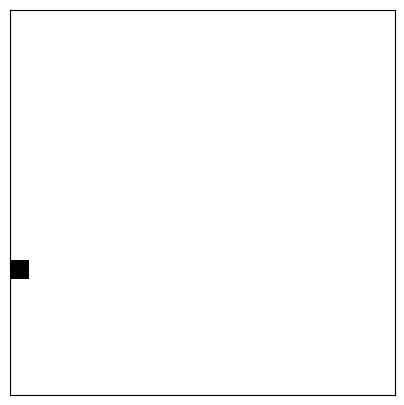

In [37]:
fig, axis = plt.subplots(figsize = (5,5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grids.iloc[0][0], cmap = plt.cm.binary)

def animate(frame):
    patch.set_data(all_grids.iloc[frame][0])

anim = animation.FuncAnimation(fig, animate, frames = total_steps)

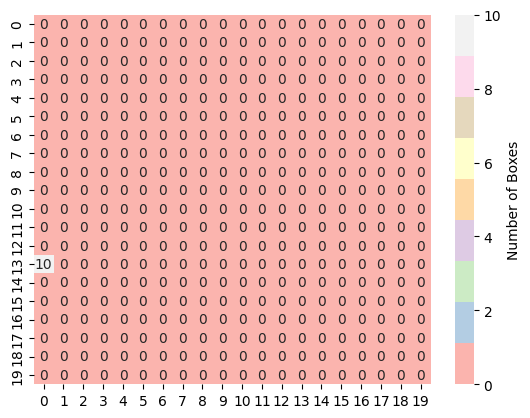

In [38]:
sns.heatmap(
    all_grids.iloc[0]["Floor"],
    annot=True, 
    fmt="g", cmap="Pastel1", 
    cbar_kws={"label": "Number of Boxes"}
)

plt.show()

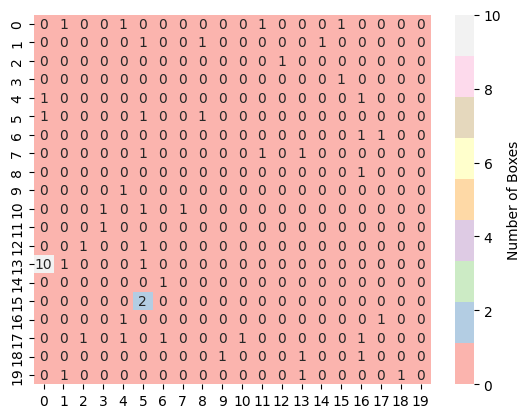

In [39]:
sns.heatmap(
    all_grids["Floor"].iloc[model.schedule.steps - 1],
    annot=True, 
    fmt="g", 
    cmap="Pastel1", 
    cbar_kws={"label": "Number of Boxes"}
)

plt.show()

In [40]:
anim

C:\Users\jn792\AppData\Local\Temp\ipykernel_13912\2793848237.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grids.iloc[frame][0])
